# Understanding Backpropagation by doing it from scratch

### Importing necessary libraries

In [2]:
import random
import torch
import torch.nn.functional as F
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

### Reading the data

In [3]:
words = open("./data/names.txt", "r").read().splitlines()
len(words)

32033

### Building the Vocabulory

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Build the Dataset

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Utility Function to compare manual gradients to Pytorch gradients

In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

### Defining all the parameters

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

### Running a Forward Pass

In [40]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3437, grad_fn=<NegBackward0>)

### Doing backprop manually
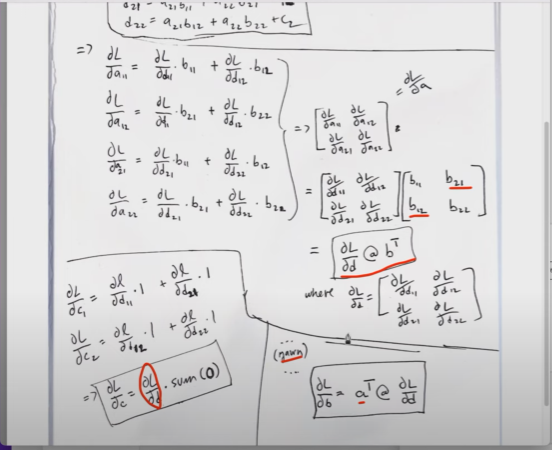

In [95]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one
# Keep in mind that the shape of the gradient and the shape of the variable for which you are computing the gradients should be same
# -----------------
# YOUR CODE HERE :)
# -----------------

# logprobs
# loss = -logprobs[range(n), Yb].mean()
# Consider L  = - (a+b+c)/3 => dL/da = -1/3, dL/db = -1/3, dL/dc = -1/3 same here
print(f'logprobs Shape: {logprobs.shape}')
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
cmp('logprobs', dlogprobs, logprobs)

# probs
# logprobs = probs.log()
# Consider L  = - (log a+ log b+ log c)/3 , dL/da = (dL/dloga)*(dloga/da)
print(f'probs Shape: {probs.shape}')
dprobs = dlogprobs*(probs**-1)
cmp('probs', dprobs, probs)

# counts_sum_inv
# probs = counts * counts_sum_inv
# Consider c = a * b but with tensors a : [3x3] and b : [3x1]-> Internally pytorch will broadcast b and make copies of b horizontally 
# a11*b1 + a12*b1 + a13*b1
# a21*b2 + a22*b2 + a23*b2
# a31*b3 + a32*b3 + a33*b3
# Multivariate Calculus :  Sum up the contributions of paths 
print(f'counts_sum_inv Shape: {counts_sum_inv.shape}')
dcounts_sum_inv = (dprobs * counts).sum(dim = 1, keepdims = True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

# counts_sum
# counts_sum_inv = counts_sum**-1
print(f'counts_sum Shape: {counts_sum.shape}')
dcounts_sum = dcounts_sum_inv*-1.0*(counts_sum**-2)
cmp('counts_sum', dcounts_sum, counts_sum)

# counts - Two contributions
# counts_sum = counts.sum(1, keepdims=True), probs = counts * counts_sum_inv
print(f'counts Shape: {counts.shape}')
dcounts = dcounts_sum*torch.ones_like(counts) + dprobs*counts_sum_inv
cmp('counts', dcounts, counts)

# norm_logits
# counts = norm_logits.exp()
print(f'norm_logits Shape: {norm_logits.shape}')
dnorm_logits = dcounts*counts
cmp('norm_logits', dnorm_logits, norm_logits)

# logit_maxes
# norm_logits = logits - logit_maxes # subtract max for numerical stability
print(f'logit_maxes Shape: {logit_maxes.shape}')
dlogit_maxes = -1.0*dnorm_logits.sum(dim = 1, keepdims = True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

# logits - Two contributions
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# logit_maxes = logits.max(1, keepdim=True).values
print(f'logits Shape: {logits.shape}')
dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(dim = 1).indices, num_classes = logits.shape[1])*dlogit_maxes
cmp('logits', dlogits, logits)

# h, W2, b2
# logits = h @ W2 + b2 # output layer
print(f'h Shape: {h.shape}, W2 Shape : {W2.shape}, b2 Shape : {b2.shape}')
dh = dlogits @ W2.T # From Matrix Derivatives as shown in the picture
cmp('h', dh, h)
dW2 = h.T@dlogits
cmp('W2', dW2, W2)
db2 = dlogits.sum(dim = 0)
cmp('b2', db2, b2)

# hpreact
# h = torch.tanh(hpreact)
print(f'hpreact Shape: {hpreact.shape}')
dhpreact = dh*(1.0-torch.tanh(hpreact)**2)
cmp('hpreact', dhpreact, hpreact)

# bngain
# hpreact = bngain * bnraw + bnbias
print(f'bngain Shape: {bngain.shape}')
dbngain = (dhpreact * bnraw).sum(dim = 0)
cmp('bngain', dbngain, bngain)

# bnbias
# hpreact = bngain * bnraw + bnbias
print(f'bnbias Shape: {bnbias.shape}')
dbnbias = dhpreact.sum(dim = 0)
cmp('bnbias', dbnbias, bnbias)

# bnraw
# hpreact = bngain * bnraw + bnbias
print(f'bnraw Shape: {bnraw.shape}')
dbnraw = dhpreact*bngain
cmp('bnraw', dbnraw, bnraw)

# bnvar_inv, bndiff
# bnraw = bndiff * bnvar_inv
print(f'bnraw Shape: {bnraw.shape}, bndiff Shape : {bndiff.shape}, bnar_inv Shape : {bnvar_inv.shape}')
dbnvar_inv = (dbnraw*bndiff).sum(dim = 0)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

# bnvar_inv = (bnvar + 1e-5)**-0.5
print(f'bnvar_inv Shape: {bnvar_inv.shape}, bnvar Shape : {bnvar.shape}')
dbnvar = dbnvar_inv*(bnvar + 1e-5)**-1.5*(-0.5)
cmp('bnvar', dbnvar, bnvar)

# bndiff2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
print(f'bndiff2 Shape: {bndiff2.shape}, bnvar Shape : {bnvar.shape}')
dbndiff2 = dbnvar*torch.ones_like(bndiff2)*(1/(n-1))
cmp('bndiff2', dbndiff2, bndiff2)

# bndiff
# bndiff2 = bndiff**2
# bnraw = bndiff * bnvar_inv
print(f'bndiff2 Shape: {bndiff2.shape}, bndiff Shape : {bndiff.shape}')
print(f'bnraw Shape: {bnraw.shape}, bndiff Shape : {bndiff.shape}, bnar_inv Shape : {bnvar_inv.shape}')
dbndiff = dbndiff2*(2*bndiff) + dbnraw*bnvar_inv
cmp('bndiff', dbndiff, bndiff)

# bnmeani
# bndiff = hprebn - bnmeani
print(f'bndiff Shape: {bndiff.shape}, bnmeani Shape : {bnmeani.shape}, hprebn Shape : {hprebn.shape}')
dbnmeani = -1.0*dbndiff.sum(dim = 0)
cmp('bnmeani', dbnmeani, bnmeani)

# hprebn
# bndiff = hprebn - bnmeani
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
print(f'bndiff Shape: {bndiff.shape}, bnmeani Shape : {bnmeani.shape}, hprebn Shape : {hprebn.shape}')
dhprebn = dbndiff + dbnmeani*torch.ones_like(hprebn)*(1/n)
cmp('hprebn', dhprebn, hprebn)

# embcat
# hprebn = embcat @ W1 + b1 # hidden layer pre-activation
print(f'hprebn Shape: {hprebn.shape}, W1 Shape : {W1.shape}, b1 Shape : {b1.shape}')
dembcat = dhprebn@W1.T
dW1 = embcat.T@dhprebn
db1 = dhprebn.sum(dim = 0)
demb = dembcat.view(emb.shape)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)

# C 
# emb = C[Xb] # embed the characters into vectors
print(f'emb Shape: {emb.shape}, C Shape : {C.shape}')
print(f'Xb Shape : {Xb.shape}')
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[i,j]
        dC[ix]+=demb[i,j]
cmp('C', dC, C)

logprobs Shape: torch.Size([32, 27])
logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs Shape: torch.Size([32, 27])
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv Shape: torch.Size([32, 1])
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum Shape: torch.Size([32, 1])
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts Shape: torch.Size([32, 27])
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits Shape: torch.Size([32, 27])
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes Shape: torch.Size([32, 1])
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits Shape: torch.Size([32, 27])
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h Shape: torch.Size([32, 64]), W2 Shape : torch.Size([64, 27]), b2 Shape : torch.Size([27])
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2   

### Backpropagating through logits: Like the way it is done in Pytorch
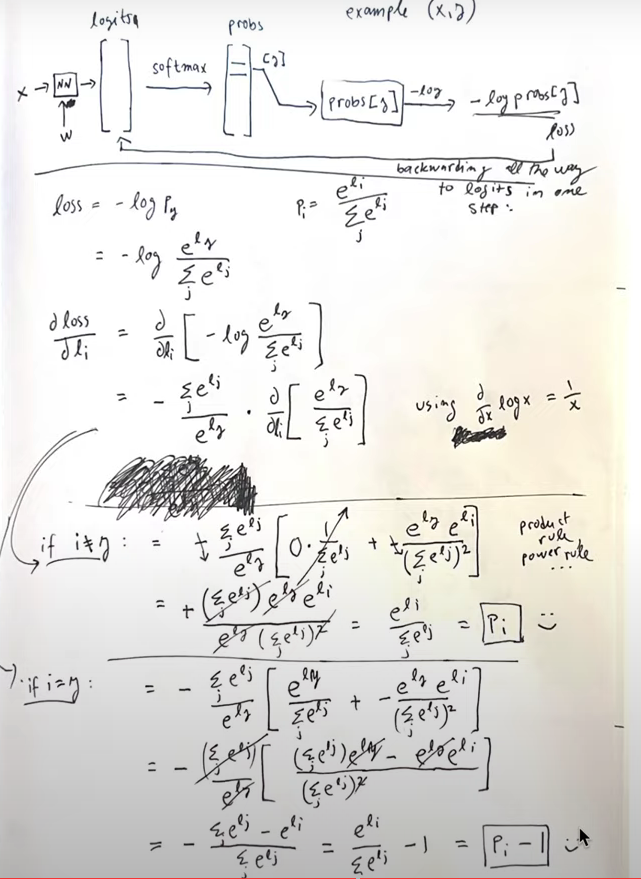

In [96]:
# Backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3437042236328125 diff: 0.0


In [97]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


In [98]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

### Visulaizing dlogits

In [99]:
F.softmax(logits, 1)[0]

tensor([0.0684, 0.0946, 0.0173, 0.0467, 0.0176, 0.0874, 0.0233, 0.0333, 0.0168,
        0.0325, 0.0364, 0.0377, 0.0355, 0.0272, 0.0351, 0.0134, 0.0087, 0.0188,
        0.0171, 0.0567, 0.0509, 0.0220, 0.0257, 0.0717, 0.0598, 0.0252, 0.0204],
       grad_fn=<SelectBackward0>)

In [100]:
dlogits[0]*n

tensor([ 0.0684,  0.0946,  0.0173,  0.0467,  0.0176,  0.0874,  0.0233,  0.0333,
        -0.9832,  0.0325,  0.0364,  0.0377,  0.0355,  0.0272,  0.0351,  0.0134,
         0.0087,  0.0188,  0.0171,  0.0567,  0.0509,  0.0220,  0.0257,  0.0717,
         0.0598,  0.0252,  0.0204], grad_fn=<MulBackward0>)

In [101]:
dlogits[0].sum()

tensor(-6.9849e-10, grad_fn=<SumBackward0>)

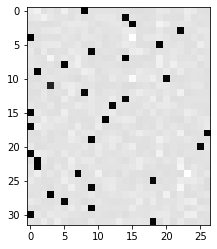

In [102]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

### Backpropagation through batchnorm : Like we do in Pytorch
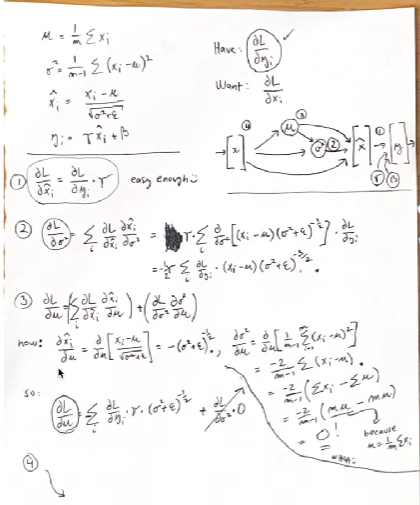

In [103]:
# Backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [104]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [105]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

### Doing backprop manually while training

#### Defining the Parameters

In [107]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    
# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

4137


In [109]:
# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
        
    # forward pass, "chunkated" into smaller steps that are possible to backward one at a time

    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer 1
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    bnmeani = 1/n*hprebn.sum(0, keepdim=True)
    bndiff = hprebn - bnmeani
    bndiff2 = bndiff**2
    bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = bndiff * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    # Linear layer 2
    logits = h @ W2 + b2 # output layer
    # cross entropy loss (same as F.cross_entropy(logits, Yb))
    logit_maxes = logits.max(1, keepdim=True).values
    norm_logits = logits - logit_maxes # subtract max for numerical stability
    counts = norm_logits.exp()
    counts_sum = counts.sum(1, keepdims=True)
    counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
    probs = counts * counts_sum_inv
    logprobs = probs.log()
    loss = -logprobs[range(n), Yb].mean()

    # PyTorch backward pass
    for p in parameters:
        p.grad = None
    
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
            
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------
    # Gradient Descent Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
        #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
        p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break